# Установка необходимых модулей

In [1]:
!pip install -U torch torchvision numpy matplotlib ipywidgets tqdm

# Импортируем библиотеки

In [2]:
from pathlib import Path
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Настройки

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Тип устройства, если есть GPU то пытаемся работать на нем
DATA_DIR = Path('data')  # Путь к датасету (папки классов внутри)
assert DATA_DIR.exists(), f'Папка DATA_DIR не найдена: {DATA_DIR}'

print('image source:', DATA_DIR)
print('device:', DEVICE)

image source: data
device: cuda


# 1 Создание нейронной сети

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=len(base_ds.classes)).to(DEVICE)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)


# 2 Работа с данными

## 2.1 Загрузка данных и первичная проверка

Данные лежат в формате `ImageFolder`:
- каждая подпапка — это отдельный класс,
- все файлы внутри подпапки относятся к этому классу.

Сначала загрузим датасет и выведем список классов и общее количество изображений.

In [7]:
IMG_SIZE = 128  # размер изображений 128 × 128 пикселей

# Для первичного анализа используем простой transform (без аугментаций)
base_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

base_ds = ImageFolder(root=DATA_DIR, transform=base_transform)

print('Всего изображений:', len(base_ds))
print('Количество классов:', len(base_ds.classes))
print('Классы:', base_ds.classes)
print('Сопоставление class_to_idx:', base_ds.class_to_idx)

x0, y0 = base_ds[0]
print('Пример одного элемента:')
print('  image tensor shape:', tuple(x0.shape))
print('  label:', y0, '(', base_ds.classes[y0], ')')

Всего изображений: 4317
Количество классов: 5
Классы: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Сопоставление class_to_idx: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Пример одного элемента:
  image tensor shape: (3, 128, 128)
  label: 0 ( daisy )


## 2.2 Статистика по файлам (сколько изображений каждого класса)

Суммарно изображений: 4317
Количество классов: 5
Картинок по классам:
            daisy: 764
        dandelion: 1052
             rose: 784
        sunflower: 733
            tulip: 984


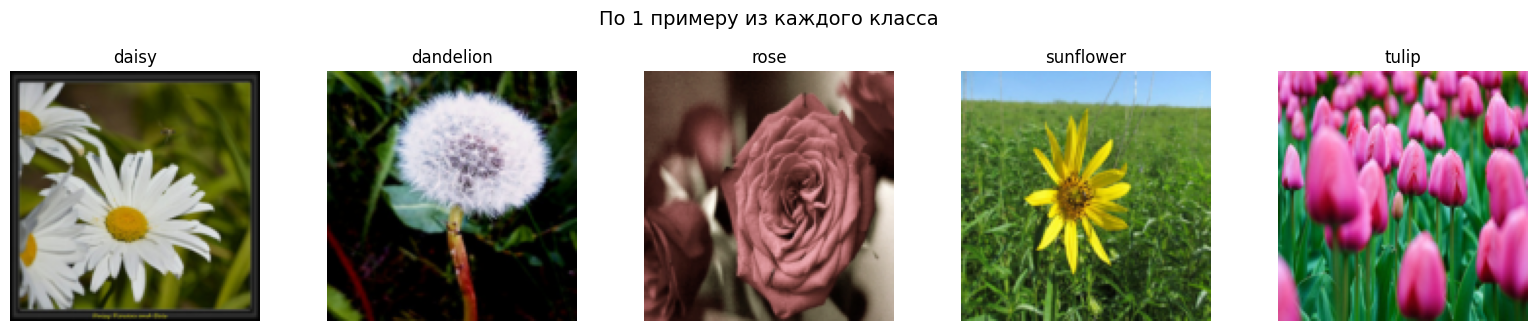

In [8]:
counts = {cls: 0 for cls in base_ds.classes}
for p, cls_idx in base_ds.samples:
    counts[base_ds.classes[cls_idx]] += 1

total = sum(counts.values())
print('Суммарно изображений:', total)
print('Количество классов:', len(counts))
print('Картинок по классам:')
for cls in sorted(counts.keys()):
    print(f'  {cls:>15s}: {counts[cls]}')

# Показать по одной случайной картинке на класс
# Соберём индексы для каждого класса
targets = np.array([y for _, y in base_ds.samples], dtype=np.int64)
indices_by_class = {i: np.where(targets == i)[0] for i in range(len(base_ds.classes))}

# Выберем по одному случайному индексу
example_indices = []

for i in range(len(base_ds.classes)):
    if len(indices_by_class[i]) == 0:
        continue
    example_indices.append(int(np.random.choice(indices_by_class[i])))

# Визуализация сеткой
n = len(example_indices)
cols = 5
rows = int(np.ceil(n / cols))

plt.figure(figsize=(3.2 * cols, 3.2 * rows))
for k, idx in enumerate(example_indices, start=1):
    img_t, y = base_ds[idx]
    img = img_t.permute(1, 2, 0).numpy()  # CHW -> HWC

    ax = plt.subplot(rows, cols, k)
    ax.imshow(img)
    ax.set_title(base_ds.classes[y])
    ax.axis('off')

plt.suptitle('По 1 примеру из каждого класса', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## 2.3 Разделение данных на наборы и нормализация

In [13]:
# Нормализация (ImageNet) — стандартный базовый вариант
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Важно: чтобы train/val/test имели разные transform, создадим 2 ImageFolder (train и eval)
train_base = ImageFolder(root=DATA_DIR, transform=train_transform)
eval_base = ImageFolder(root=DATA_DIR, transform=eval_transform)

N = len(train_base)
indices = np.arange(N)
np.random.shuffle(indices)

n_train = int(0.70 * N)
n_val = int(0.15 * N)
n_test = N - n_train - n_val

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

train_ds = Subset(train_base, train_idx.tolist())
val_ds = Subset(eval_base, val_idx.tolist())
test_ds = Subset(eval_base, test_idx.tolist())

print('Размеры выборок:')
print('  train:', len(train_ds))
print('  val  :', len(val_ds))
print('  test :', len(test_ds))

# Статистика по классам в каждом сплите
targets_all = np.array([y for _, y in train_base.samples], dtype=np.int64)

def split_class_counts(idxs: np.ndarray):
    c = np.bincount(targets_all[idxs], minlength=len(train_base.classes))
    return c

c_train = split_class_counts(train_idx)
c_val = split_class_counts(val_idx)
c_test = split_class_counts(test_idx)

print('\nРаспределение по классам (train/val/test):')
for i, name in enumerate(train_base.classes):
    print(f'  {name:>15s}: {int(c_train[i])} / {int(c_val[i])} / {int(c_test[i])}')

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print('\nПараметры DataLoader:')
print('  batch_size:', BATCH_SIZE)
print('  num_workers:', 0)

Размеры выборок:
  train: 3021
  val  : 647
  test : 649

Распределение по классам (train/val/test):
            daisy: 497 / 127 / 140
        dandelion: 743 / 159 / 150
             rose: 544 / 119 / 121
        sunflower: 529 / 106 / 98
            tulip: 708 / 136 / 140

Параметры DataLoader:
  batch_size: 32
  num_workers: 0


# 3 Обучение нейросети

train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 01/8 | train_loss=1.2648, train_acc=0.4499 | val_loss=1.2575, val_acc=0.4513


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 02/8 | train_loss=1.2140, train_acc=0.4641 | val_loss=1.2249, val_acc=0.4374


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 03/8 | train_loss=1.1833, train_acc=0.4734 | val_loss=1.2226, val_acc=0.5008


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 04/8 | train_loss=1.1505, train_acc=0.5065 | val_loss=1.1780, val_acc=0.4683


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 05/8 | train_loss=1.1341, train_acc=0.5141 | val_loss=1.1667, val_acc=0.5224


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 06/8 | train_loss=1.1130, train_acc=0.5263 | val_loss=1.1335, val_acc=0.5425


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 07/8 | train_loss=1.0907, train_acc=0.5511 | val_loss=1.1112, val_acc=0.5410


train:   0%|          | 0/95 [00:00<?, ?it/s]

val:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 08/8 | train_loss=1.0501, train_acc=0.5743 | val_loss=1.0726, val_acc=0.5873
Загружены лучшие веса по val_loss: 1.0726169347763062


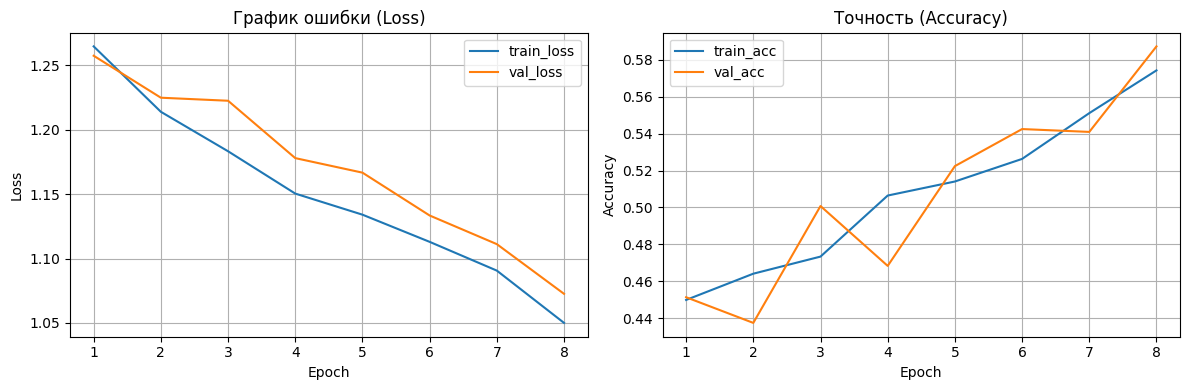

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def batch_correct(logits: torch.Tensor, y: torch.Tensor):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y).sum()
    return correct, y.numel()

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = torch.tensor(0.0, device=DEVICE)
    total_correct = torch.tensor(0, device=DEVICE)
    total_seen = 0

    pbar = tqdm(loader, desc=('train' if is_train else 'val'), leave=False)

    for x, y in pbar:
        # быстрее перенос на GPU (если loader с pin_memory=True)
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        # аккумулируем без .item() на каждом батче
        bs = y.size(0)
        total_loss += loss.detach() * bs

        correct, seen = batch_correct(logits.detach(), y)
        total_correct += correct
        total_seen += seen

        # postfix делаем из GPU тензоров (но .item() всё равно синхронизирует)
        # поэтому лучше обновлять реже:
        if total_seen % (loader.batch_size * 10) == 0:
            pbar.set_postfix({
                'loss': (total_loss / total_seen).item(),
                'acc': (total_correct.float() / total_seen).item()
            })

    epoch_loss = (total_loss / total_seen).item()
    epoch_acc = (total_correct.float() / total_seen).item()
    return epoch_loss, epoch_acc

EPOCHS = 8  # для CPU можно начать с 8, потом увеличить

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
}

best_val_loss = float('inf')
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f'Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')

# Восстановим лучшие веса по val_loss
if best_state is not None:
    model.load_state_dict(best_state)
    print('Загружены лучшие веса по val_loss:', best_val_loss)

# Графики loss и accuracy
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='train_loss')
plt.plot(epochs, history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('График ошибки (Loss)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='train_acc')
plt.plot(epochs, history['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Точность (Accuracy)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 4 Проверка на тестовом наборе

test:   0%|          | 0/21 [00:00<?, ?it/s]

test_loss: 1.0741
test_acc : 57.32%

Численные значения по классам:
  class | support | TP | recall(%) | error(%) | FN
            daisy |     140 | 59 |    42.14 |   57.86 |  81
        dandelion |     150 | 106 |    70.67 |   29.33 |  44
             rose |     121 | 44 |    36.36 |   63.64 |  77
        sunflower |      98 | 72 |    73.47 |   26.53 |  26
            tulip |     140 | 91 |    65.00 |   35.00 |  49


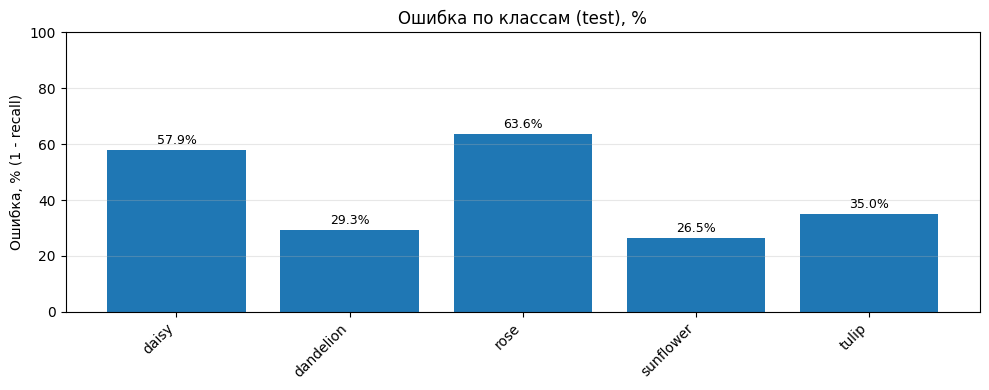

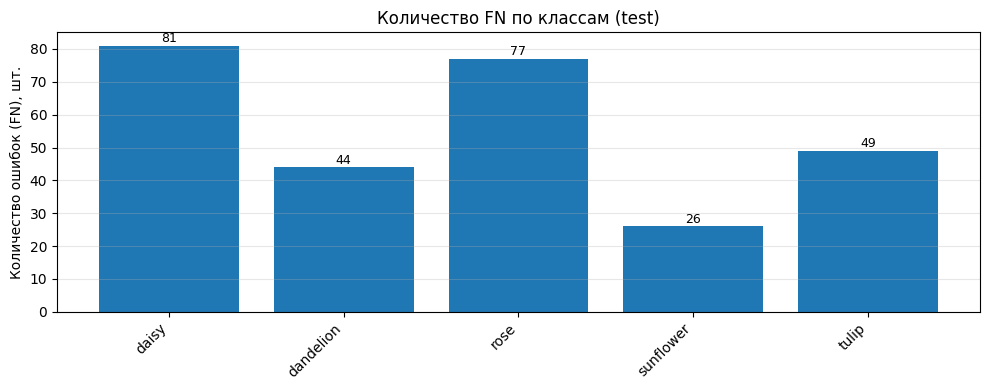

In [17]:
model.eval()

y_true, y_pred = [], []
test_loss_sum = 0.0
n_batches = 0

with torch.no_grad():
    for x, y in tqdm(test_loader, desc='test'):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        loss = criterion(logits, y)

        preds = torch.argmax(logits, dim=1)

        y_true.append(y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

        test_loss_sum += float(loss.item())
        n_batches += 1

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

test_loss = test_loss_sum / max(n_batches, 1)
test_acc = float((y_true == y_pred).mean())

print(f'test_loss: {test_loss:.4f}')
print(f'test_acc : {test_acc * 100.0:.2f}%')

# Confusion matrix
C = len(train_base.classes)
cm = np.zeros((C, C), dtype=np.int64)
for t, p in zip(y_true, y_pred):
    cm[int(t), int(p)] += 1

# Метрики по классам
class_names = train_base.classes

support = cm.sum(axis=1)                 # сколько объектов класса было в тесте
tp = np.diag(cm)                         # сколько угадали в каждом классе (True Positive)
recall = tp / (support + 1e-12)          # recall по классам
class_error = 1.0 - recall               # ошибка = 1 - recall
fn = support - tp                        # FN по классам

recall_pct = recall * 100.0
class_error_pct = class_error * 100.0

print('\nЧисленные значения по классам:')
print('  class | support | TP | recall(%) | error(%) | FN')
for i, name in enumerate(class_names):
    print(
        f'  {name:>15s} | {int(support[i]):7d} | {int(tp[i]):2d} | '
        f'{recall_pct[i]:8.2f} | {class_error_pct[i]:7.2f} | {int(fn[i]):3d}'
    )

# График ошибки по классам, %
plt.figure(figsize=(10, 4))
plt.bar(np.arange(C), class_error_pct)
plt.xticks(np.arange(C), class_names, rotation=45, ha='right')
plt.ylim(0, 100)
plt.ylabel('Ошибка, % (1 - recall)')
plt.title('Ошибка по классам (test), %')
plt.grid(axis='y', alpha=0.3)

# подписи процентов над столбиками
for i, v in enumerate(class_error_pct):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# График количества FN по классам (шт.)
plt.figure(figsize=(10, 4))
plt.bar(np.arange(C), fn)
plt.xticks(np.arange(C), class_names, rotation=45, ha='right')
plt.ylabel('Количество ошибок (FN), шт.')
plt.title('Количество FN по классам (test)')
plt.grid(axis='y', alpha=0.3)

# подписи значений над столбиками
for i, v in enumerate(fn):
    plt.text(i, v + 0.2, f'{int(v)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()